## PINNs Solving Mass-Spring With Friction

### Environment setup
We begin by importing various libraries

In [130]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

We then create a neural network. Here we are creating 2 hidden layers, each with 128 neurons and using GELU as the activation function. We are also creating an identical neural network that will be trained without physics.

In [131]:
PINN = tf.keras.models.Sequential([
    tf.keras.layers.Input((1,)),
    tf.keras.layers.Dense(units = 128, activation = 'gelu'),
    tf.keras.layers.Dense(units = 128, activation = 'gelu'),
    tf.keras.layers.Dense(units = 1)
])

NN = tf.keras.models.Sequential([
    tf.keras.layers.Input((1,)),
    tf.keras.layers.Dense(units = 128, activation = 'gelu'),
    tf.keras.layers.Dense(units = 128, activation = 'gelu'),
    tf.keras.layers.Dense(units = 1)
])

PINN.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_93 (Dense)            (None, 128)               256       
                                                                 
 dense_94 (Dense)            (None, 128)               16512     
                                                                 
 dense_95 (Dense)            (None, 1)                 129       
                                                                 
Total params: 16897 (66.00 KB)
Trainable params: 16897 (66.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Differential Equation of the System

Consider the mass-spring with friction DE:
$$my''+by'+ky=0$$
Whose solutions are of the form
$$y(t)=Ae^{\alpha t}\sin(\beta t+\phi)$$

### Deriving the Loss Terms
We then obtain the following $\mathcal{L}_{phys}$
$$\mathcal{L}_{phys}=\frac{1}{M}\sum_{i=1}^M (\hat{m}\hat{y}''_i+\hat{b}\hat{y}'_i+\hat{k}\hat{y}_i)^2$$

Of course we also have our $\mathcal{L}_{data}$, which is typical MSE
$$\mathcal{L}_{data}=\frac{1}{N}\sum_{i=1}^N(y_i-\hat{y}_i)^2$$

We then get our final loss $\mathcal{L}$ by apply weights
$$\mathcal{L}=w_{data}\mathcal{L}_{data}+w_{phys}\mathcal{L}_{phys}$$

In [132]:
# Calculates the loss from both physics and data
# ttrain is the t-values for the set of training data
# ytrain is the y-values for the set of training data
# tphys is the t-values for training the physics
# m is the mass parameter
# b is the friction parameter
# k is the spring parameter
# net is the network we are training
# wd is the data weight
# wp is the physics weight
# wb is the bc weight
def train(ttrain, ytrain, tphys, m, b, k, net, wd, wp):
    ttrain = ttrain.reshape(-1,1)
    ttrain = tf.constant(ttrain, dtype = tf.float32)

    tphys = tphys.reshape(-1,1)
    tphys = tf.constant(tphys, dtype = tf.float32)

    yhat = net(ttrain)

    with tf.GradientTape() as tape1:
        tape1.watch(tphys)
        with tf.GradientTape() as tape2:
            tape2.watch(tphys)

            # Get our yhat and first derivative
            yphys = net(tphys)
            yphys_t = tape2.gradient(yphys, tphys)
        # Get our second derivative
        yphys_t2 = tape1.gradient(yphys_t, tphys)

    # Compute loss from the ode
    ode_loss = m * yphys_t2 + b * yphys_t + k * yphys
    
    # Compute loss from the data
    data_loss = yhat - ytrain

    # Compute the total loss
    total_loss = wd * tf.reduce_mean(tf.square(data_loss)) + wp * tf.reduce_mean(tf.square(ode_loss))

    return total_loss

## Obtaining Data
We would now obtain data from experiments in the real-world to train our model on.

In our case, we will create some synthetic training data. We also add some noise into our data.

In [133]:
# Generate training data from known values
train_t = np.linspace(0, 5, 20).reshape(-1, 1)
phys_t = np.linspace(0, 20, 500).reshape(-1, 1)
train_y = (40 / np.sqrt(47)) * np.exp(-1.0/8.0 * train_t) * np.sin(np.sqrt(47)/8.0 * train_t)
# Add some noise to the data
for train_y_cur in train_y:
    train_y_cur += 0.2 * random.random() - 0.1

test_t = np.linspace(0, 20, 40)
test_y = (40 / np.sqrt(47)) * np.exp(-1.0/8.0 * test_t) * np.sin(np.sqrt(47)/8.0 * test_t)

## Training the Model
We perform the actual training to determine the model and the values of $m$, $b$, and $k$.

If we aim to learn all three value simultaneously, we likely will not obtain the original values, as uniqueness is not guranteed. However, if we provide the true values for 2 variables, the model is able to learn the third. 

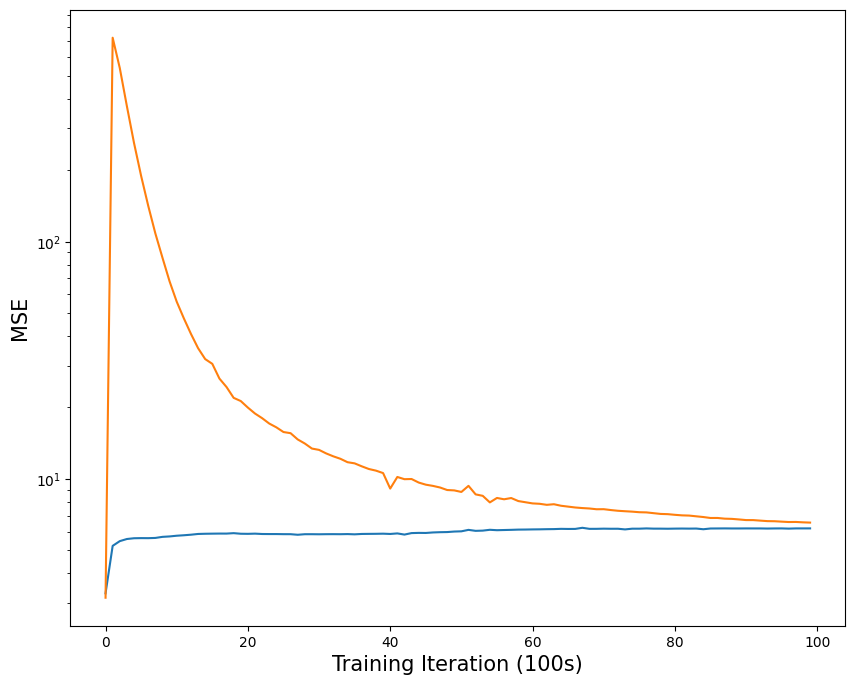

In [134]:
# Assume we know m=4 and b=1, but do not know what k is
m = tf.Variable(initial_value=4.0,trainable=False, dtype=tf.float32)
b = tf.Variable(initial_value=1.0,trainable=False, dtype=tf.float32)
k1 = tf.Variable(initial_value=1.0,trainable=True, dtype=tf.float32)
k2 = tf.Variable(initial_value=1.0,trainable=True, dtype=tf.float32)


optm1 = tf.keras.optimizers.Adam(learning_rate = 0.001)
optm2 = tf.keras.optimizers.Adam(learning_rate = 0.001)

test_loss_record1 = []
test_loss_record2 = []

# Train the models
for itr in range(10000):
    with tf.GradientTape() as tape1:
        train_loss = train(train_t, train_y, phys_t, m, b, k1, PINN, 1, 1) 
        grad_w1 = tape1.gradient(train_loss, PINN.trainable_variables + [k1])
        optm1.apply_gradients(zip(grad_w1, PINN.trainable_variables + [k1]))
    with tf.GradientTape() as tape2:
        train_loss = train(train_t, train_y, phys_t, m, b, k2, NN, 1, 0)
        grad_w2 = tape2.gradient(train_loss, NN.trainable_variables + [k2])
        optm2.apply_gradients(zip(grad_w2, NN.trainable_variables + [k2]))

    if itr % 100 == 0:
        err1 = test_y - PINN(test_t)
        err2 = test_y - NN(test_t)

        test_loss_record1.append(tf.reduce_mean(tf.square(err1)))
        test_loss_record2.append(tf.reduce_mean(tf.square(err2))) 

# Plot the loss against the iterations
plt.figure(figsize = (10,8))
plt.plot(test_loss_record1)
plt.plot(test_loss_record2)
plt.xlabel('Training Iteration (100s)', fontsize = 15)
plt.ylabel('MSE', fontsize = 15)
plt.yscale('log')
plt.show()

## Comparing to the True Solution
We also plot the model against the true solution.

The true solution to the IVP with $m=4$, $b=1$, $k=3$, $y(0)=0$, $y'(0)=5$ is
$$y(t)=\frac{40}{\sqrt{47}}e^{-\frac{1}{8}t}\sin(\frac{\sqrt{47}}{8}t)$$

We plot our model's prediction against the true solution, and compare our estimated value of $k$.

2/2 [==============================] - 0s 2ms/step
Estimated k (Physics): 2.89710259
Estimated k (No Physics): 1


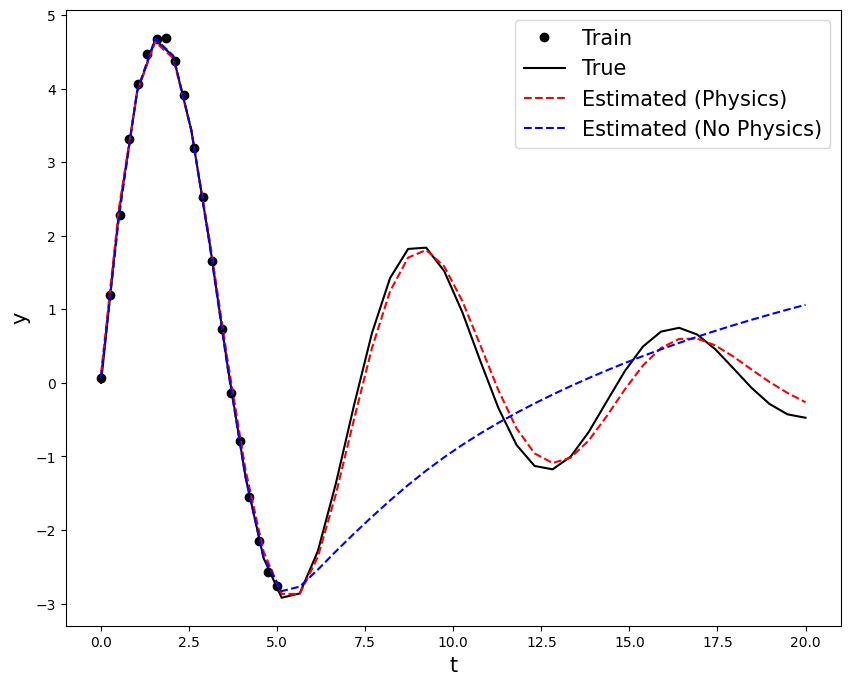

In [135]:
# Test the model
pred_y1 = PINN.predict(test_t).ravel()
pred_y2 = NN.predict(test_t).ravel()

tf.print("Estimated k (Physics):", k1)
tf.print("Estimated k (No Physics):", k2)

plt.figure(figsize = (10,8))
plt.plot(train_t, train_y, 'ok', label = 'Train')
plt.plot(test_t, test_y, '-k',label = 'True')
plt.plot(test_t, pred_y1, '--r', label = 'Estimated (Physics)')
plt.plot(test_t, pred_y2, '--b', label = 'Estimated (No Physics)')
plt.legend(fontsize = 15)
plt.xlabel('t', fontsize = 15)
plt.ylabel('y', fontsize = 15)
plt.show()